# SQL Injection Detection Using Fine-Tuned BERT Models

This notebook demonstrates the process of detecting SQL injection attacks using fine-tuned BERT models. We aim to leverage the powerful NLP capabilities of BERT, enhanced through fine-tuning, to accurately classify SQL queries into benign or malicious categories.

## Overview

- **Dataset Loading and Exploration**: Understand the dataset's structure and prepare it for modeling.
- **Model Setup**: Configure BERT for the classification task.
- **Baseline Model Performance**: Evaluate the pre-fine-tuned model's performance.
- **Fine-Tuning**: Enhance the model by fine-tuning it with a custom dataset.
- **Evaluation and Visualization**: Compare the model's performance before and after fine-tuning.


## Step 1: Load the Dataset

We begin by loading the dataset and performing basic exploration to understand its structure.

In [1]:
import pandas as pd

# Load the dataset
dataset_path = './SQL Query Dataset.csv'
df = pd.read_csv(dataset_path)

# Display the first few rows of the dataset
print(df.head())

                                               Query  Label
0                  " or pg_sleep  (  __TIME__  )  --      1
1  create user name identified by pass123 tempora...      1
2   AND 1  =  utl_inaddr.get_host_address   (    ...      1
3   select * from users where id  =  '1' or @ @1 ...      1
4   select * from users where id  =  1 or 1#"  ( ...      1


## Step 2: Basic Dataset Exploration

Missing values in each column:
 Query    0
Label    0
dtype: int64
Class distribution:
 Label
0    19537
1    11382
Name: count, dtype: int64
Basic statistics on query lengths:
 count    30919.000000
mean        68.882888
std         81.144952
min          1.000000
25%         21.000000
50%         48.000000
75%         81.000000
max       5370.000000
Name: query_length, dtype: float64


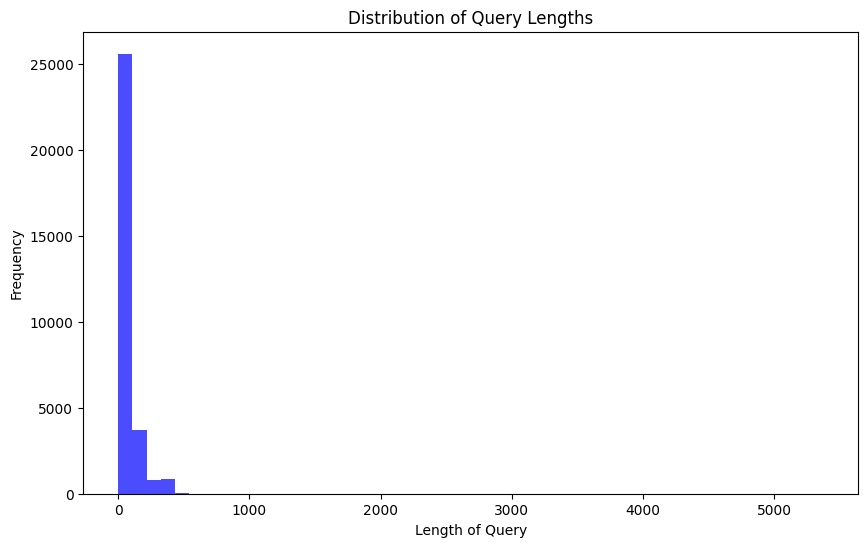

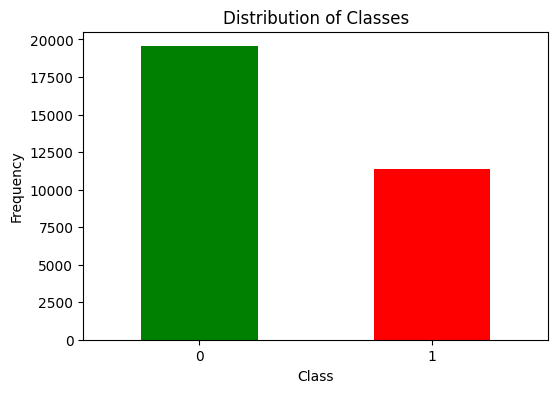

In [2]:
# Check for any missing values in the dataset
missing_values = df.isnull().sum()
print("Missing values in each column:\n", missing_values)

# If there are any missing values in 'text' or 'label' columns, you might need to drop or impute them
df = df.dropna()

# Check the distribution of the target classes
class_distribution = df['Label'].value_counts()
print("Class distribution:\n", class_distribution)

# Basic statistics on the length of the queries
df['query_length'] = df['Query'].apply(len)
print("Basic statistics on query lengths:\n", df['query_length'].describe())

# Visualizing the distribution of query lengths
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.hist(df['query_length'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Query Lengths')
plt.xlabel('Length of Query')
plt.ylabel('Frequency')
plt.show()

# Displaying the balance of the dataset
plt.figure(figsize=(6, 4))
df['Label'].value_counts().plot(kind='bar', color=['green', 'red'])
plt.title('Distribution of Classes')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.xticks(rotation=0)
plt.show()

## Step 3: Preparing Text Data for BERT

In [3]:
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
import torch
from sklearn.model_selection import train_test_split

# Tokenize all texts in the dataset
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")
input_ids = []
attention_masks = []

for text in df["Query"]:
    encoded_dict = tokenizer.encode_plus(
        text,  # Text to encode.
        add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
        max_length=64,  # Pad & truncate all sentences.
        pad_to_max_length=True,
        return_attention_mask=True,  # Construct attention masks.
        return_tensors="pt",  # Return PyTorch tensors.
    )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict["input_ids"])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict["attention_mask"])

# Convert lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(df["Label"].values)

# Split the data into train and validation sets.
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(
    input_ids, labels, random_state=42, test_size=0.1
)
train_masks, validation_masks, _, _ = train_test_split(
    attention_masks, labels, random_state=42, test_size=0.1
)

# Create the DataLoader for our training set.
train_dataset = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=32)

# Create the DataLoader for our validation set.
validation_dataset = TensorDataset(
    validation_inputs, validation_masks, validation_labels
)
validation_sampler = SequentialSampler(validation_dataset)
validation_dataloader = DataLoader(
    validation_dataset, sampler=validation_sampler, batch_size=32
)

print("Dataset loaded and preprocessed for BERT.")

c:\Users\aweso\AppData\Local\Programs\Python\Python38\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\aweso\AppData\Local\Programs\Python\Python38\lib\site-packages\transformers\tokenization_utils_base.py:2688: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a 

Dataset loaded and preprocessed for BERT.


## Step 4: Set Up the BERT Model for Classification

Initialize the BERT model, configure the optimizer and learning rate scheduler.

In [4]:
from transformers import BertForSequenceClassification, AdamW
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
import torch

# Specify the number of output labels
num_labels = 2  # Example for binary classification

epochs = 5

# Load the BERT model for sequence classification
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased",  # Use the 12-layer BERT model, with an uncased vocab.
    num_labels=num_labels,  # The number of output labels. 2 for binary classification.
    output_attentions=False,  # Whether the model returns attentions weights.
    output_hidden_states=False,  # Whether the model returns all hidden-states.
)

# Tell PyTorch to run the model on GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,  # Recommended learning rate for BERT fine-tuning
    eps=1e-8,  # AdamW's epsilon for numerical stability
)

# Total number of training steps is [number of batches] x [number of epochs]
# (Note: This doesn’t take into account any additional splitting of the training data)
total_steps = len(train_dataloader) * epochs  # epochs is a value you define earlier

# Set up the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=total_steps  # Default value
)

print("BERT model is set up with optimizer and learning rate scheduler.")

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BERT model is set up with optimizer and learning rate scheduler.


## Step 5: Train the Model

Outline the training loop, including calculating and logging metrics during training.

In [5]:
import numpy as np
import torch
import time
import datetime


# Helper function for calculating elapsed time
def format_time(elapsed):
    """
    Takes a time in seconds and returns a string hh:mm:ss
    """
    # Round to the nearest second
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

def flat_accuracy(preds, labels):
    """
    Function to calculate the accuracy of our predictions vs labels.
    Args:
    preds: Predictions from the model.
    labels: Ground truth labels.
    Returns:
    A float representing the accuracy of the predictions.
    """
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)


# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print("======== Epoch {:} / {:} ========".format(epoch_i + 1, epochs))
    print("Training...")

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print(
                "  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.".format(
                    step, len(train_dataloader), elapsed
                )
            )

        # Unpack this training batch from our dataloader and copy each tensor to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a backward pass
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch)
        # The documentation for this `model` function is here:
        # https://huggingface.co/transformers/v2.2.0/model_doc/bert.html#transformers.BertForSequenceClassification
        result = model(
            b_input_ids,
            token_type_ids=None,
            attention_mask=b_input_mask,
            labels=b_labels,
            return_dict=True,
        )

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients
        loss.backward()

        # Clip the norm of the gradients to 1.0 to help prevent the "exploding gradients" problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient
        optimizer.step()

        # Update the learning rate
        scheduler.step()

    # Calculate the average loss over all of the batches
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on our validation set

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this batch to the GPU
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training)
        with torch.no_grad():

            # Forward pass, calculate logit predictions
            result = model(
                b_input_ids,
                token_type_ids=None,
                attention_mask=b_input_mask,
                labels=b_labels,
                return_dict=True,
            )

        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to("cpu").numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches
        total_eval_accuracy += flat_accuracy(logits, label_ids)

    # Report the final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch
    training_stats.append(
        {
            "epoch": epoch_i + 1,
            "Training Loss": avg_train_loss,
            "Valid. Loss": avg_val_loss,
            "Valid. Accur.": avg_val_accuracy,
            "Training Time": training_time,
            "Validation Time": validation_time,
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time() - total_t0)))


======== Epoch 1 / 5 ========
Training...
  Batch    40  of    870.    Elapsed: 0:10:15.


## Step 6: Evaluate Model Performance

Use the trained model to predict on the validation set and evaluate its performance.

In [ ]:
from sklearn.metrics import classification_report

# Put model in evaluation mode to evaluate loss on the validation set
model.eval()

# Tracking variables
predictions, true_labels = [], []

# Predict
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    logits = outputs.logits

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to("cpu").numpy()

    # Store predictions and true labels
    predictions.append(logits)
    true_labels.append(label_ids)

# Flatten the predictions and true labels
flat_predictions = np.concatenate(predictions, axis=0)
flat_true_labels = np.concatenate(true_labels, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()

# Calculate the accuracy for this batch of test sentences, and accumulate it over all batches
evaluation_accuracy = np.mean(flat_predictions == flat_true_labels)

# Use classification report to get precision, recall and F1 score
evaluation_report = classification_report(
    flat_true_labels, flat_predictions, target_names=["non-malicious", "malicious"]
)

print("Validation Accuracy: {:.3f}".format(evaluation_accuracy))
print("Classification Report:\n", evaluation_report)

## Step 7: Visualize Embeddings

Visualize the embeddings generated by the model to inspect the cluster formations before and after fine-tuning.

In [ ]:
from transformers import BertModel
import torch

# Loading the same configuration as your BertForSequenceClassification, but with BertModel
model = BertModel.from_pretrained("bert-base-uncased")

# Put model in evaluation mode
model.eval()
model.to(device)

# Collect the embeddings
embeddings = []

# We'll use the same validation_dataloader to get embeddings
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)

    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    # Telling the model not to compute or store gradients, saving memory and speeding up prediction
    with torch.no_grad():
        # Forward pass, get model outputs
        outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)

    # Get the embeddings from the last layer
    last_hidden_states = outputs.last_hidden_state
    # Use the mean of the last layer hidden states as the sentence embedding
    sentence_embeddings = torch.mean(last_hidden_states, dim=1)
    embeddings.append(sentence_embeddings.cpu().numpy())

# Concatenate all embeddings
embeddings = np.concatenate(embeddings, axis=0)

from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# Use t-SNE to reduce the dimensionality of embeddings to two dimensions
tsne = TSNE(n_components=2, random_state=42)
embeddings_reduced = tsne.fit_transform(embeddings)

# Plotting the reduced embeddings
plt.figure(figsize=(12, 8))
sns.scatterplot(
    embeddings_reduced[:, 0],
    embeddings_reduced[:, 1],
    hue=flat_true_labels,
    palette="coolwarm",
)
plt.title("t-SNE of BERT Embeddings")
plt.xlabel("t-SNE dimension 1")
plt.ylabel("t-SNE dimension 2")
plt.show()

## Conclusion

Summarize the findings from the model performance and embedding visualizations.